# Introduction

Notebook to analyze the **False Negatives** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner import tc_br_strat_runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
vol_strat_runner = tc_br_strat_runner.TC_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

lsi_model_4 = vol_strat_runner.get_lsi_model()
lda_model_4 = vol_strat_runner.get_lda_model()
bm25_model_4 = vol_strat_runner.get_bm25_model()
w2v_model_4 = vol_strat_runner.get_word2vec_model()

oracle = vol_strat_runner.get_oracle()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

OracleVolunteers.shape: (195, 91)
TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_10_cosine_0.0,33.08,23.46,26.09,precision recall fscore ...,0.0,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_10_cosine_0.1,33.08,23.46,26.09,precision recall fscore ...,0.1,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_10_cosine_0.2,33.08,23.46,26.09,precision recall fscore ...,0.2,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_10_cosine_0.3,33.08,23.46,26.09,precision recall fscore ...,0.3,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_10_cosine_0.4,32.99,23.28,25.97,precision recall fscore ...,0.4,10.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

#### Min Recall

model
bm25          14.20
lda            2.59
lsi            1.88
wordvector     3.61
Name: perc_recall, dtype: float64



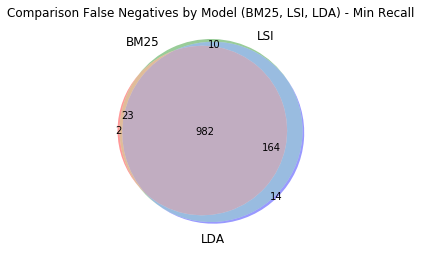

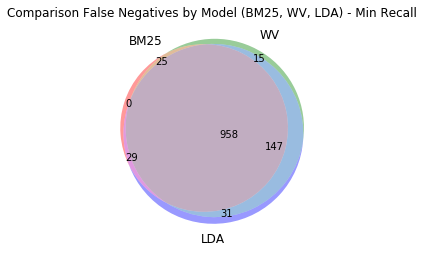

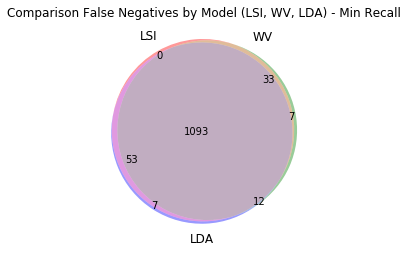

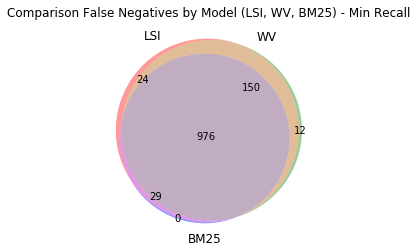

In [6]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


{('TC_105_TRG', 'BR_1300738_SRC'),
 ('TC_14_TRG', 'BR_1294733_SRC'),
 ('TC_14_TRG', 'BR_1294887_SRC'),
 ('TC_75_TRG', 'BR_1248267_SRC'),
 ('TC_76_TRG', 'BR_1248267_SRC'),
 ('TC_77_TRG', 'BR_1248267_SRC'),
 ('TC_93_TRG', 'BR_1248267_SRC')}



WV Exclusive FN:


{('TC_154_TRG', 'BR_1292566_SRC'),
 ('TC_162_TRG', 'BR_1292566_SRC'),
 ('TC_164_TRG', 'BR_1292566_SRC'),
 ('TC_170_TRG', 'BR_1292566_SRC'),
 ('TC_18_TRG', 'BR_1357458_SRC')}

#### Max Recall

model
bm25          32.54
lda           33.25
lsi           46.99
wordvector    12.62
Name: perc_recall, dtype: float64



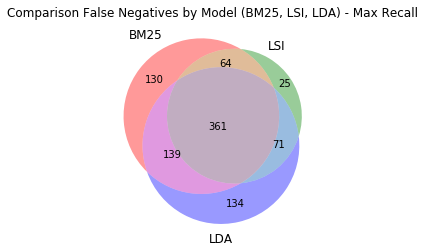

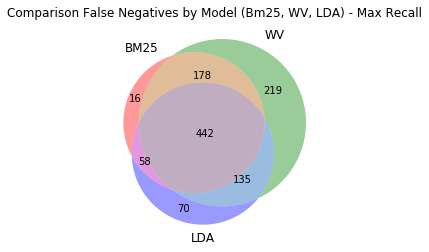

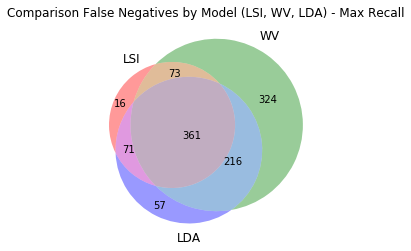

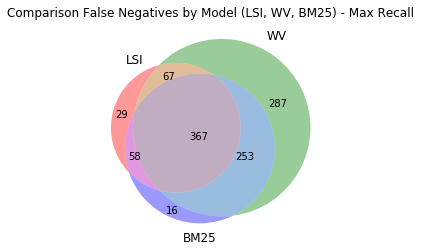

In [8]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [9]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FN:
len(bm25_exc_set): 6


LSI Exclusive FN:
len(lsi_exc_set): 6


LDA Exclusive FN:
len(lda_exc_set): 47


WV Exclusive FN:
len(wv_exc_set): 200


##### Word Clouds

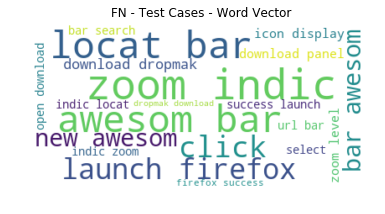

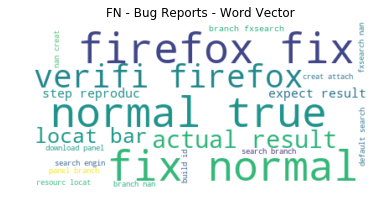

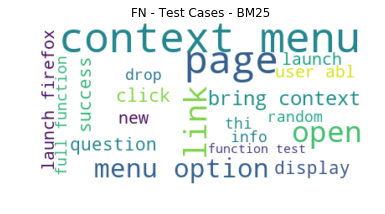

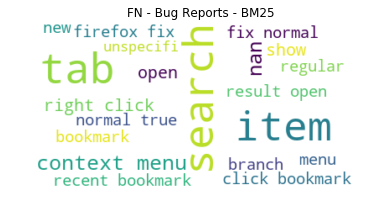

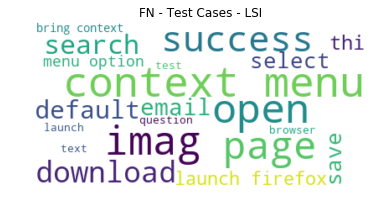

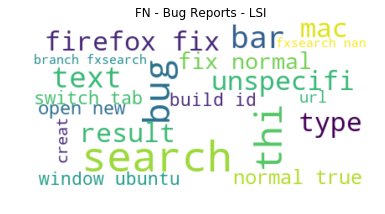

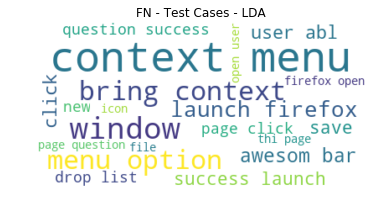

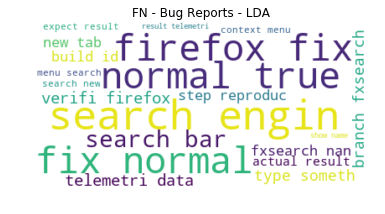

In [10]:
aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - Word Vector",
                                    wc_br_title="FN - Bug Reports - Word Vector")

aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - BM25",
                                    wc_br_title="FN - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LSI",
                                   wc_br_title="FN - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LDA",
                                    wc_br_title="FN - Bug Reports - LDA")


In [11]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 521
LDA FN Amount: 705
BM25 FN Amount: 694
WV FN Amount: 974


##### Detailing Features for Exclusive Sets

In [12]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_74_TRG,Context Menu,BR_1248267_SRC,"Right click on bookmark item of ""Recently Bookmarked"" should show regular places context menu"
1,TC_78_TRG,Context Menu,BR_1248267_SRC,"Right click on bookmark item of ""Recently Bookmarked"" should show regular places context menu"
2,TC_92_TRG,Context Menu,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu
3,TC_95_TRG,Context Menu,BR_1248267_SRC,"Right click on bookmark item of ""Recently Bookmarked"" should show regular places context menu"
4,TC_85_TRG,Context Menu,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
5,TC_14_TRG,New Awesome Bar,BR_1451475_SRC,Renew scalar browser.engagement.restored_pinned_tabs_count


,tc,tc_feat,br,br_summary
0,TC_160_TRG,Downloads Dropmaker,BR_1432915_SRC,Do not write the kMDItemWhereFroms xattr metadata for files downloaded in Private Browsing mode
1,TC_159_TRG,Downloads Dropmaker,BR_1432915_SRC,Do not write the kMDItemWhereFroms xattr metadata for files downloaded in Private Browsing mode
2,TC_14_TRG,New Awesome Bar,BR_1279864_SRC,The new location bar autocomplete drop down menu starting from 48 has serious performance issue and often blocks user's <Enter> input
3,TC_187_TRG,Indicator for device permissions,BR_1290424_SRC,"Mouse-over (hover) on a dropdown suggestion (search, URL) causes the hovered-over item to be deleted on 'delete'-press"
4,TC_14_TRG,New Awesome Bar,BR_1339497_SRC,firefox tries to load incorrect url if urlbar autocomplete suggests first-two-letters-duplicated hosts when input url contains % encoded components
5,TC_14_TRG,New Awesome Bar,BR_1365887_SRC,Can't open resource:///modules/ from the location bar
6,TC_185_TRG,Indicator for device permissions,BR_1290424_SRC,"Mouse-over (hover) on a dropdown suggestion (search, URL) causes the hovered-over item to be deleted on 'delete'-press"
7,TC_188_TRG,Indicator for device permissions,BR_1290424_SRC,"Mouse-over (hover) on a dropdown suggestion (search, URL) causes the hovered-over item to be deleted on 'delete'-press"
8,TC_100_TRG,Context Menu,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu
9,TC_96_TRG,Context Menu,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu


,tc,tc_feat,br,br_summary
0,TC_122_TRG,WebGL Compatibility,BR_1312018_SRC,Keyword search is always performed in lowercase
1,TC_88_TRG,Context Menu,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
2,TC_162_TRG,Downloads Dropmaker,BR_1432915_SRC,Do not write the kMDItemWhereFroms xattr metadata for files downloaded in Private Browsing mode
3,TC_99_TRG,Context Menu,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
4,TC_59_TRG,Browser Customization,BR_1357458_SRC,After Customization - typed text in the Awesome bar doesn't correspond with the text from One-Off-Searches bar
5,TC_100_TRG,Context Menu,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"


,tc,tc_feat,br,br_summary
0,TC_16_TRG,New Awesome Bar,BR_1335992_SRC,Search with default search engine stops working
1,TC_154_TRG,Downloads Dropmaker,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
2,TC_15_TRG,New Awesome Bar,BR_1294733_SRC,Awesomebar search buttons show auto completed text not user input
3,TC_22_TRG,New Awesome Bar,BR_1291770_SRC,"[HiDPI] Globe icon is too small, ends up being scaled up"
4,TC_169_TRG,Downloads Dropmaker,BR_1292573_SRC,Broken keyboard interaction with the subview in the Downloads Panel
5,TC_19_TRG,New Awesome Bar,BR_1291770_SRC,"[HiDPI] Globe icon is too small, ends up being scaled up"
6,TC_18_TRG,New Awesome Bar,BR_1328913_SRC,Pref-off Search Reset UI for beta and release
7,TC_64_TRG,Browser Customization,BR_1353831_SRC,OneOff block in search bar doesn't update text if Customize was opened at least once
8,TC_24_TRG,New Awesome Bar,BR_1291770_SRC,"[HiDPI] Globe icon is too small, ends up being scaled up"
9,TC_198_TRG,Zoom Indicator,BR_1365887_SRC,Can't open resource:///modules/ from the location bar


#### Min Precision

model
bm25          14.04
lda            6.94
lsi            9.07
wordvector     6.21
Name: perc_precision, dtype: float64



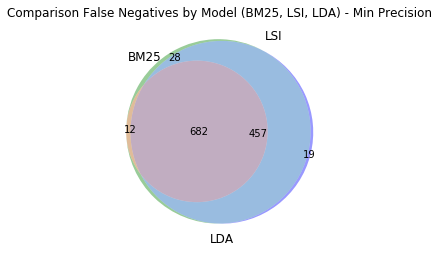

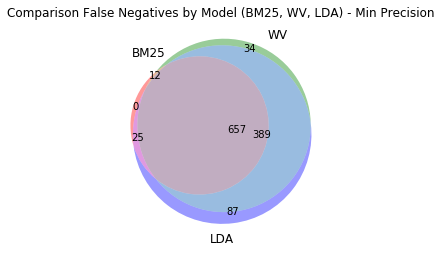

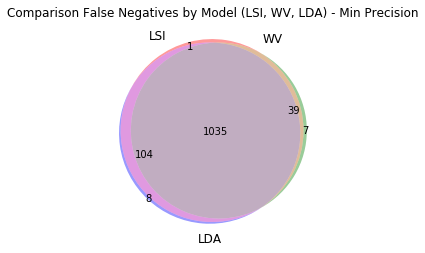

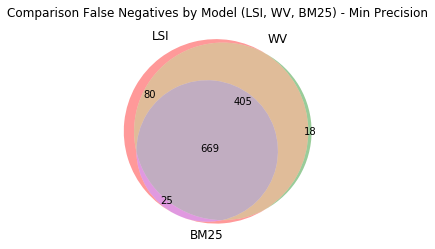

In [13]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [14]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


{('TC_92_TRG', 'BR_1248267_SRC')}



LDA Exclusive FN:


{('TC_105_TRG', 'BR_1300738_SRC'),
 ('TC_106_TRG', 'BR_1300738_SRC'),
 ('TC_14_TRG', 'BR_1294733_SRC'),
 ('TC_14_TRG', 'BR_1294887_SRC'),
 ('TC_75_TRG', 'BR_1248267_SRC'),
 ('TC_76_TRG', 'BR_1248267_SRC'),
 ('TC_77_TRG', 'BR_1248267_SRC'),
 ('TC_93_TRG', 'BR_1248267_SRC')}



WV Exclusive FN:


{('TC_154_TRG', 'BR_1292566_SRC'),
 ('TC_156_TRG', 'BR_1292566_SRC'),
 ('TC_162_TRG', 'BR_1292566_SRC'),
 ('TC_164_TRG', 'BR_1292566_SRC'),
 ('TC_165_TRG', 'BR_1292566_SRC'),
 ('TC_170_TRG', 'BR_1292566_SRC'),
 ('TC_18_TRG', 'BR_1357458_SRC')}

In [15]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 1179
LDA FN Amount: 1158
BM25 FN Amount: 694
WV FN Amount: 1092


#### Max Precision

model
bm25          21.21
lda           20.03
lsi           33.80
wordvector     6.85
Name: perc_precision, dtype: float64



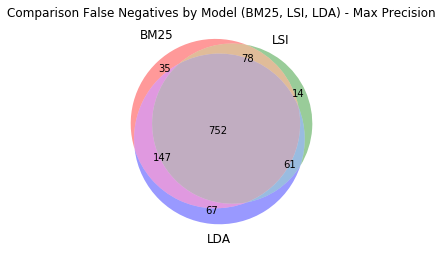

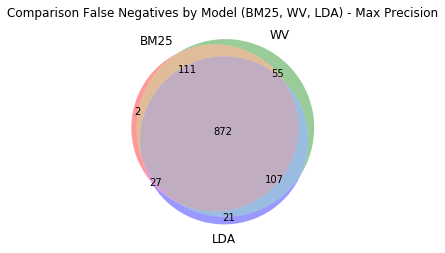

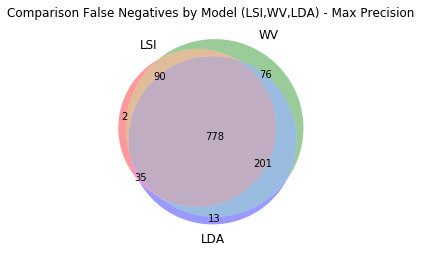

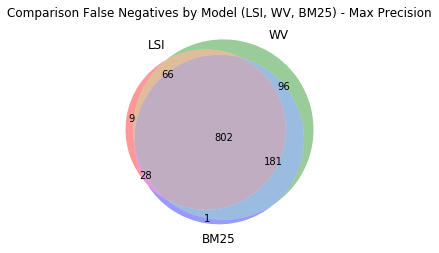

In [16]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [17]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


{('TC_14_TRG', 'BR_1279864_SRC'),
 ('TC_14_TRG', 'BR_1294887_SRC'),
 ('TC_14_TRG', 'BR_1301421_SRC'),
 ('TC_14_TRG', 'BR_1328913_SRC'),
 ('TC_14_TRG', 'BR_1335992_SRC'),
 ('TC_14_TRG', 'BR_1352539_SRC'),
 ('TC_14_TRG', 'BR_1353831_SRC'),
 ('TC_183_TRG', 'BR_1345687_SRC'),
 ('TC_195_TRG', 'BR_1345687_SRC'),
 ('TC_205_TRG', 'BR_1305195_SRC'),
 ('TC_88_TRG', 'BR_1299458_SRC'),
 ('TC_93_TRG', 'BR_1248267_SRC')}



WV Exclusive FN:


{('TC_104_TRG', 'BR_1300738_SRC'),
 ('TC_106_TRG', 'BR_1300738_SRC'),
 ('TC_13_TRG', 'BR_1297374_SRC'),
 ('TC_13_TRG', 'BR_1335992_SRC'),
 ('TC_13_TRG', 'BR_1352539_SRC'),
 ('TC_144_TRG', 'BR_1365887_SRC'),
 ('TC_145_TRG', 'BR_1365887_SRC'),
 ('TC_148_TRG', 'BR_1365887_SRC'),
 ('TC_154_TRG', 'BR_1287384_SRC'),
 ('TC_154_TRG', 'BR_1292566_SRC'),
 ('TC_157_TRG', 'BR_1292573_SRC'),
 ('TC_158_TRG', 'BR_1287384_SRC'),
 ('TC_158_TRG', 'BR_1292573_SRC'),
 ('TC_15_TRG', 'BR_1294733_SRC'),
 ('TC_15_TRG', 'BR_1294887_SRC'),
 ('TC_15_TRG', 'BR_1297374_SRC'),
 ('TC_15_TRG', 'BR_1352539_SRC'),
 ('TC_15_TRG', 'BR_1353831_SRC'),
 ('TC_162_TRG', 'BR_1292566_SRC'),
 ('TC_164_TRG', 'BR_1292566_SRC'),
 ('TC_165_TRG', 'BR_1287384_SRC'),
 ('TC_169_TRG', 'BR_1287384_SRC'),
 ('TC_16_TRG', 'BR_1353831_SRC'),
 ('TC_16_TRG', 'BR_1357458_SRC'),
 ('TC_170_TRG', 'BR_1287384_SRC'),
 ('TC_170_TRG', 'BR_1292566_SRC'),
 ('TC_17_TRG', 'BR_1305737_SRC'),
 ('TC_180_TRG', 'BR_1345687_SRC'),
 ('TC_181_TRG', 'BR_1345687_SRC

In [18]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 905
LDA FN Amount: 1027
BM25 FN Amount: 1012
WV FN Amount: 1145
